In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
# import ipynb_importer
# import utils

In [2]:
transform = transforms.Compose([
#     transforms.Resize(196),
#     transforms.CenterCrop(224),
    transforms.ToTensor()
])

train = torchvision.datasets.MNIST(root='./', train=True, transform=transform, download=True)
test = torchvision.datasets.MNIST(root='./', train=False, transform=transform, download=True)
# train.data = train.data.float() / 255.0
# train.data = (train.data - torch.mean(train.data, dim=(1,2), keepdim=True)) / torch.std(train.data, dim=(1,2), keepdim=True)
# test.data = test.data / 255.0

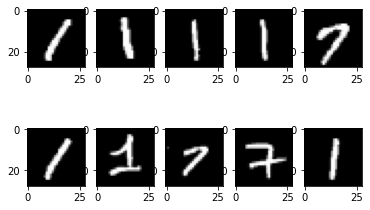

In [3]:
def binary_class(data, classes):
    # classes is a list of two numbers
    idx = torch.where(torch.isin(data.targets, torch.Tensor(classes)))[0]
    idx_1 = torch.where(data.targets[idx] == classes[0])[0]
    idx_2 = torch.where(data.targets[idx] == classes[1])[0]
    binary_labels = torch.zeros(len(idx))
    binary_labels[idx_2] = 1.0
    dataset = torch.utils.data.TensorDataset(data.data[idx] / 255.0, binary_labels)
    dataset.data = data.data[idx] / 255.0
    return dataset, idx_1, idx_2

classes = [1,7]
train_binary, idx_1, idx_2 = binary_class(train, classes)
test_binary,_,_ = binary_class(test, classes)

# sanity check: input data
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(train_binary[i][0], cmap='gray')

batch_size = 64
# Dataloader
trainloader_binary = torch.utils.data.DataLoader(train_binary, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_binary = torch.utils.data.DataLoader(test_binary, batch_size=batch_size, shuffle=False, num_workers=2)

In [4]:
# model architecture
M = len(torch.flatten(train[0][0]))
n1 = 16
n1_junk = 64
n_classes = 10
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [5]:
from torch import nn
import torch.nn.functional as F

def training(model, dataloader, optimizer, criterion, num_epoch=10, device='cpu', binary=False, correlation=False):
    model.to(device)
    model.train()
    accuracy = []
    if correlation:
        corr = []
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = torch.squeeze(torch.flatten(inputs, start_dim=2), dim=1).float()
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if binary:
                predicted = torch.where(output.data < 0.5, 0, 1)
            else:
                _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy.append(running_loss/total)
        print('(Epoch %d) loss: %.3f, accuracy: %.3f'%(epoch, running_loss/total, correct/total))
    return model

In [6]:
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=2)

In [7]:
# pre-training w1
class pre_one_layer(torch.nn.Module):
    def __init__(self, M, n1, n_classes):
        super().__init__()
        self.M = M
        self.n1 = n1
        w1s = torch.Tensor(self.M).to(device)
        self.w1s = torch.nn.Parameter(w1s, requires_grad=True)
        torch.nn.init.uniform_(self.w1s, -1.0/np.sqrt(M), 1.0/np.sqrt(M))
        self.fc2 = nn.Linear(n1, n_classes, bias=False)
            
    def forward(self, x):
        k = int(self.M/self.n1)
        weight = torch.reshape(torch.ones(k).to(device), (1,1,-1))
        x = F.conv1d(torch.unsqueeze(x*self.w1s, 1), weight, stride=k)
        x = torch.squeeze(x,1)
        x = F.relu(x)
        x = self.fc2(x)
        return x

batch_size = 64
# Dataloader
model_pre_one = pre_one_layer(M, n1, n_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pre_one.parameters())
num_epoch = 10
model_pre_one = training(model_pre_one, trainloader, optimizer, criterion, num_epoch=num_epoch, device=device)
w1 = list(model_pre_one.parameters())[0]
torch.save(w1, 'w1s_16.pt')

(Epoch 0) loss: 0.018, accuracy: 0.662
(Epoch 1) loss: 0.009, accuracy: 0.823
(Epoch 2) loss: 0.009, accuracy: 0.835
(Epoch 3) loss: 0.008, accuracy: 0.841
(Epoch 4) loss: 0.008, accuracy: 0.843
(Epoch 5) loss: 0.008, accuracy: 0.846
(Epoch 6) loss: 0.008, accuracy: 0.849
(Epoch 7) loss: 0.008, accuracy: 0.851
(Epoch 8) loss: 0.008, accuracy: 0.852
(Epoch 9) loss: 0.008, accuracy: 0.853


In [7]:
w1 = torch.load('w1s_16.pt').data
# print(w1)
k = int(M/n1)
flat = torch.flatten(train_binary.data.float(), start_dim=1)*w1.to('cpu')
weight = torch.reshape(torch.ones(k), (1,1,-1))
lambda_1 = torch.mean(F.relu(F.conv1d(torch.unsqueeze(flat, 1), weight, stride=k)), dim=0)
print(lambda_1)

tensor([[7.4439e-05, 0.0000e+00, 1.8218e-01, 6.3010e-01, 3.5977e+00, 1.4765e+00,
         3.0691e+00, 2.2165e+00, 1.3078e+00, 2.7264e+00, 5.1896e-01, 9.5002e-01,
         4.8166e-01, 1.7840e+00, 9.1615e-01, 5.1843e-01]])


In [8]:
class baseline_one_layer(torch.nn.Module):
    def __init__(self, n1, w1, n1_junk, junk=False, junk_mean=None, sigma_junk=None):
        super().__init__()
        self.w1 = w1
        self.n1 = n1
        self.n1_junk = n1_junk
        self.junk = junk
        self.junk_mean = junk_mean
        self.sigma_junk = sigma_junk
        if junk:
            n1_actual = n1 + n1_junk
        else:
            n1_actual = n1
        self.gain_layer = nn.Linear(n1_actual, 1, bias=False)

    def forward(self, x):
        k = int(len(self.w1)/self.n1)
        weight = torch.reshape(torch.ones(k), (1,1,-1)).to(device)
        x = F.conv1d(torch.unsqueeze(torch.flatten(x, start_dim=1)*w1,1), weight, stride=k)
        x = torch.squeeze(x, 1)
        x = F.relu(x)
        if self.junk:
            x = torch.cat((x, torch.normal(self.junk_mean, self.sigma_junk, size=(x.size()[0],self.n1_junk)).to(device)),
                         dim=1)
        x = self.gain_layer(x)
        x = torch.sigmoid(x)
        x = torch.squeeze(x, dim=-1)
        return x

junk = True
junk_mean = torch.mean(lambda_1).item()
# junk_mean = 0.0
sigma_junk = torch.std(lambda_1).item()
model_baseline_one = baseline_one_layer(n1, w1, n1_junk, junk, junk_mean, sigma_junk)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model_baseline_one.parameters())
num_epoch = 10
model_baseline_one = training(model_baseline_one, trainloader_binary, 
                              optimizer, criterion, num_epoch=num_epoch, device=device, binary=True)

(Epoch 0) loss: 0.008, accuracy: 0.754
(Epoch 1) loss: 0.004, accuracy: 0.967
(Epoch 2) loss: 0.003, accuracy: 0.975
(Epoch 3) loss: 0.002, accuracy: 0.978
(Epoch 4) loss: 0.002, accuracy: 0.980
(Epoch 5) loss: 0.001, accuracy: 0.982
(Epoch 6) loss: 0.001, accuracy: 0.982
(Epoch 7) loss: 0.001, accuracy: 0.984
(Epoch 8) loss: 0.001, accuracy: 0.985
(Epoch 9) loss: 0.001, accuracy: 0.986


In [9]:
class modulator_one_layer(torch.nn.Module):
    # allow the flexibility of adding junk neurons
    # allow the flexibility of weight correction
    def __init__(self, n1, w1, m, sigma_m, T, tanh_k, a_cont, lr_a, sigma_w, sigma_s, device='cpu',
                 junk=False, junk_mean=None, sigma_junk=None, n1_junk=None, correction=True):
        # m is of size (batch)
        super().__init__()
        self.n1 = n1
        self.w1 = w1
        self.m = m
        self.sigma_m = sigma_m
        self.T = T
        self.tanh_k = tanh_k
        self.a_cont = a_cont
        self.lr_a = lr_a
        self.device = device
        self.junk = junk
        if junk:
            self.n1_junk = n1_junk
            self.junk_mean = junk_mean
            self.sigma_junk = sigma_junk
            self.n1_actual = n1 + n1_junk
        else:
            self.n1_actual = n1
        w = torch.Tensor(self.n1_actual).to(device)
        s = torch.Tensor(self.n1_actual).to(device)
#         s = torch.Tensor(self.n1).to(device)
        self.w = torch.nn.Parameter(w, requires_grad=True)
        self.s = torch.nn.Parameter(s)
        torch.nn.init.normal_(self.w, 0, sigma_w)
        torch.nn.init.normal_(self.s, 0, sigma_s)
        self.count = 0

    def forward(self, x):
        k = int(len(self.w1)/self.n1)
        weight = torch.reshape(torch.ones(k), (1,1,-1)).to(device)
        x = F.conv1d(torch.unsqueeze(torch.flatten(x, start_dim=1)*w1,1), weight, stride=k)
        x = torch.squeeze(x, 1)
        x = F.relu(x)
        if junk:
#             print(x.size())
#             print(torch.mean(x))
            x = torch.cat((x, torch.normal(self.junk_mean, self.sigma_junk, size=(x.size()[0],self.n1_junk)).to(device)),
                         dim=1)
        if correction:
            fluc = torch.exp(torch.outer(self.m, self.w) - self.sigma_m*self.sigma_m*self.w*self.w/2.0) # (T, num_neurons)
        else:
            fluc = torch.exp(torch.outer(self.m, self.w))
        k = torch.mul(torch.unsqueeze(x, dim=0), torch.unsqueeze(fluc, dim=1)) # (T, batch, num_neurons)
        a = torch.sum(torch.mul(torch.reshape(self.m, (-1,1,1)), k), dim=0) / self.T # (batch, num_neurons)
#         print(a)
        a = self.lr_a * a + (1-self.lr_a) * a_cont
        if self.count > 10000:
#             tanh_k_ = self.tanh_k * np.log(self.count)
            tanh_k_ = 1000.0 # an arbitrary large number
        else:
            tanh_k_ = self.tanh_k
        sign = torch.tanh(tanh_k_ * self.s) # (n1_actual)
        # one sample can only compute the gradient once
        x = torch.sum(sign * a * torch.mean(k, dim=0), dim=1)
#         print([torch.sum((sign * a * torch.mean(k, dim=0))[0,:16]), torch.sum((sign * a * torch.mean(k, dim=0))[0,16:])])
        x = torch.sigmoid(x)
        self.a_cont = torch.mean(a, dim=0)
#         print(self.a_cont)
        self.count += x.size()[0]
        return x

In [57]:
sigma_w = 0.3
sigma_s = 0.02
sigma_m = 0.1
# m_mean = 0.0
m_mean = 1.0
# T = 50
T = 200
m = torch.normal(m_mean, sigma_m, size=(T,))
m = m.to(device)
lr_a = 0.1
tanh_k = 10.0
# tanh_k = 50.0
junk = True
junk_mean = torch.mean(lambda_1).item()
# junk_mean = 0.0
sigma_junk = torch.std(lambda_1).item()
if junk:
    a_cont = torch.normal(0, 0.1, size=(n1 + n1_junk,))
else:
    a_cont = torch.normal(0, 0.1, size=(n1,))
a_cont = a_cont.to(device)
correction = True

model_modulator_one = modulator_one_layer(n1, w1, m, sigma_m, T, tanh_k, a_cont, lr_a, sigma_w, sigma_s, device=device,
                 junk=junk, junk_mean=junk_mean, sigma_junk=sigma_junk, n1_junk=n1_junk, correction=correction)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam([{'params': list(model_modulator_one.parameters())[0], 'lr':0.01},
                              {'params': list(model_modulator_one.parameters())[1]}])
num_epoch = 10
model_modulator_one = training(model_modulator_one, trainloader_binary, 
                              optimizer, criterion, num_epoch=num_epoch, device=device, binary=True)

(Epoch 0) loss: 0.004, accuracy: 0.909
(Epoch 1) loss: 0.002, accuracy: 0.983
(Epoch 2) loss: 0.001, accuracy: 0.986
(Epoch 3) loss: 0.001, accuracy: 0.988
(Epoch 4) loss: 0.001, accuracy: 0.988
(Epoch 5) loss: 0.001, accuracy: 0.988
(Epoch 6) loss: 0.001, accuracy: 0.989
(Epoch 7) loss: 0.001, accuracy: 0.989
(Epoch 8) loss: 0.001, accuracy: 0.990
(Epoch 9) loss: 0.001, accuracy: 0.990


In [58]:
w = list(model_modulator_one.parameters())[0]
s = list(model_modulator_one.parameters())[1]

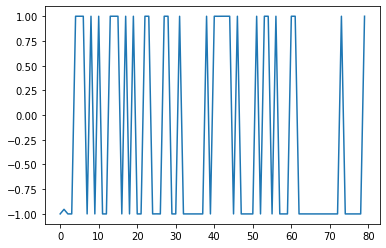

In [59]:
plt.plot(np.tanh(1000*s.cpu().detach().numpy()))

In [60]:
k = int(M/n1)
flat_1 = torch.flatten(train_binary.data.float()[list(idx_1)], start_dim=1)*w1.to('cpu')
flat_2 = torch.flatten(train_binary.data.float()[list(idx_2)], start_dim=1)*w1.to('cpu')
weight = torch.reshape(torch.ones(k), (1,1,-1))
lambda_c1 = torch.squeeze(F.relu(F.conv1d(torch.unsqueeze(flat_1, 1), weight, stride=k)), 1)
lambda_c2 = torch.squeeze(F.relu(F.conv1d(torch.unsqueeze(flat_2, 1), weight, stride=k)), 1)
l1, sd1 = torch.mean(lambda_c1, dim=0), torch.std(lambda_c1, dim=0)
l2, sd2 = torch.mean(lambda_c2, dim=0), torch.std(lambda_c2, dim=0)
d_prime = torch.abs(l1-l2) / (torch.sqrt(sd1*sd1+sd2*sd2) / 2.0 + 0.001)

In [61]:
np.corrcoef(w.cpu().detach().numpy()[:n1], d_prime.cpu().detach().numpy())

array([[1.        , 0.39895617],
       [0.39895617, 1.        ]])

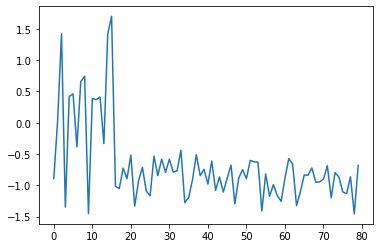

In [40]:
plt.plot(w.cpu().detach().numpy())

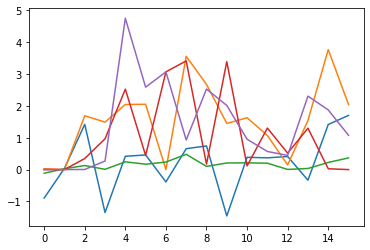

In [41]:
plt.plot(w.cpu().detach().numpy()[:16])
plt.plot(d_prime.cpu().detach().numpy())
plt.plot(model_modulator_one.a_cont.cpu().detach().numpy()[:16])
plt.plot(l1)
plt.plot(l2)

In [30]:
print(junk_mean)

1.2734737396240234


In [31]:
print(sigma_junk)

1.118826150894165


array([[1.        , 0.63341834],
       [0.63341834, 1.        ]])

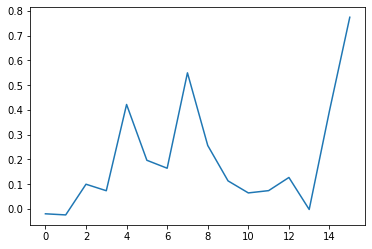

In [32]:
# plt.plot(d_prime.cpu().detach().numpy())
plt.plot(model_modulator_one.a_cont.cpu().detach().numpy()[:16])
np.corrcoef(d_prime.cpu().detach().numpy(), model_modulator_one.a_cont.cpu().detach().numpy()[:16])

In [22]:
model_modulator_one.a_cont.size()

torch.Size([80])